# Amazon Bedrock AgentCore Observability with LangGraph Agent hosted outside of AgentCore Runtime

This notebook demonstrates how to use setup observability for a [LangGraph](https://langchain-ai.github.io/langgraph/) agent hosted outside of Amazon Bedrock AgentCore Runtime. Once you have completed the setup, you will be able to view the internal decision making process of LangGraph agent in GenAI Observability dashboard in Amazon CloudWatch.

## What you'll learn
- How to set up LangGraph Agent with Amazon OpenTelemetry Python Instrumentation
- How to visualize and analyze agent traces in CloudWatch GenAI Observability


## Prerequisites
- Enable transaction search on Amazon CloudWatch. First-time users must enable CloudWatch Transaction Search to view Bedrock AgentCore spans and traces. To enable transaction search, please refer to the our [documentation](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/Enable-TransactionSearch.html).
- Log group and Log stream configured on Amazon Cloudwatch to be added to the environment variables.
- AWS account with Amazon Bedrock Model access to Claude Haiku with Model ID: anthropic.claude-3-haiku-20240307-v1:0
- AWS credentials configured using `aws configure` 
- .env file updated with environment variables variables. An example is provided in `Langgraph/.env.example`

## 1. Setup and Installation

First, let's install the required dependencies. Please check that `aws-opentelemetry-distro` in your requirements.txt file.  

In [ ]:
 #!pip install -r requirements.txt

## 2. Environment Configuration
To enable observability for your LangGraph agent and send telemetry data to Amazon CloudWatch, you'll need to configure the following environment variables. We use a `.env` file to manage these settings securely, keeping sensitive AWS credentials separate from your code while making it easy to switch between different environments.

Create a `.env` file with your AWS credentials and configuration. Use `Langgraph/.env.example` as a template.

If you are using an existing `log group` and corresponding `log stream`, please add that to your environment variable. 

Else, you would need to **create** a log group and log stream in Cloudwatch before you set that as an environment variable, example names are provided.

Required Environment Variables:

| Variable | Value | Purpose |
|----------|-------|---------|
| `OTEL_PYTHON_DISTRO` | `aws_distro` | Use AWS Distro for OpenTelemetry (ADOT) |
| `OTEL_PYTHON_CONFIGURATOR` | `aws_configurator` | Set AWS configurator for ADOT SDK |
| `OTEL_EXPORTER_OTLP_PROTOCOL` | `http/protobuf` | Configure export protocol |
| `OTEL_EXPORTER_OTLP_LOGS_HEADERS` | `x-aws-log-group=<YOUR-LOG-GROUP>,x-aws-log-stream=<YOUR-LOG-STREAM>,x-aws-metric-namespace=<YOUR-NAMESPACE>` | Direct logs to CloudWatch groups |
| `OTEL_RESOURCE_ATTRIBUTES` | `service.name=<YOUR-AGENT-NAME>` | Identify your agent in observability data |
| `AGENT_OBSERVABILITY_ENABLED` | `true` | Activate ADOT pipeline |
| `AWS_REGION` | `<YOUR-REGION>` | AWS Region |

## 3. Load Environment Variables

Let's load the environment variables from the `.env` file:

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Display the OTEL-related environment variables
otel_vars = [
    "OTEL_PYTHON_DISTRO",
    "OTEL_PYTHON_CONFIGURATOR",
    "OTEL_EXPORTER_OTLP_PROTOCOL",
    "OTEL_EXPORTER_OTLP_LOGS_HEADERS",
    "OTEL_RESOURCE_ATTRIBUTES",
    "AGENT_OBSERVABILITY_ENABLED",
    "OTEL_TRACES_EXPORTER"
]

print("OpenTelemetry Configuration:")
for var in otel_vars:
    value = os.getenv(var)
    if value:
        print(f"{var}={value}")

## 4. Create a LangGraph Agent in a python file

LangGraph Travel Agent implementation is provided in `langgraph_travel_agent.py`. It is a Travel Agent set up with the model from Amazon Bedrock. The LangGraph agent is setup with OpenTelemetry and the AWS OpenTelemetry distro will automatically handle tracer provider setup when using `opentelemetry-instrument` command.

The agent is a simple travel recommendation agent that:

- Creates a conversational AI agent using AWS Bedrock's Claude Haiku model
- Uses LangGraph's state management for conversation flow
- Integrates web search capabilities using DuckDuckGo
- Handles tool calling and conditional routing based on the agent's decisions
- Returns travel recommendations based on user queries

The Agent is Configured with the following: 

- State management using TypedDict for message handling
- Tool integration with conditional edges for decision making
- Amazon Bedrock's Claude Haiku model as the Large Language Model
- Web search tool for real-time information retrieval
- Session-based conversation tracking

The `graph` is created and executed using `graph.invoke` in the file.

In [ ]:
%%writefile langgraph_travel_agent.py
import os
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from duckduckgo_search import DDGS

os.environ["LANGSMITH_OTEL_ENABLED"] = "true"

@tool("web_search")
def web_search(query: str) -> str:
    """Search the web for current information about destinations, attractions, events, and general topics."""
    try:
        ddgs = DDGS()
        results = ddgs.text(query, max_results=5)
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No summary')}\n"
                f"   Source: {result.get('href', 'No URL')}\n"
            )
        
        return "\n".join(formatted_results) if formatted_results else "No results found."
        
    except Exception as e:
        return f"Search error: {str(e)}"

def get_llm():
    model_id = os.getenv("BEDROCK_MODEL_ID", "us.anthropic.claude-3-5-haiku-20241022-v1:0")
    
    try:
        llm = init_chat_model(
            model_id,
            model_provider="bedrock_converse",
            temperature=0.0,
            max_tokens=512,
        )
        return llm
    except Exception as e:
        raise

llm = get_llm()
tools = [web_search]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    try:
        response = llm_with_tools.invoke(state["messages"])
        return {"messages": [response]}
    except Exception as e:
        from langchain_core.messages import AIMessage
        error_response = AIMessage(content=f"I apologize, but I encountered an error: {str(e)}")
        return {"messages": [error_response]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()
graph_configured = True

def agent_invocation(payload: str, session_id: str = "default_session"):
    try:
        config = {"configurable": {"session_id": session_id}}
        tmp_msg = {"messages": [{"role": "user", "content": payload}]}
        
        tmp_output = graph.invoke(tmp_msg, config=config)
        
        result = tmp_output['messages'][-1].content
        
        return {
            "result": result,
            "status": "success",
            "session_id": session_id
        }
        
    except Exception as e:
        return {
            "result": "I apologize, but I encountered an error processing your request. Please try again.",
            "status": "error",
            "error": str(e),
            "session_id": session_id
        }

def run_agent_with_task(task_description: str, session_id: str = "task_session"):
    enhanced_prompt = f"""
    You are an experienced research agent with access to real-time web information.
    Your task is: {task_description}
    
    Please provide a comprehensive response with:
    1. Current and accurate information (use web search when needed)
    2. Practical details and recommendations
    3. Clear structure and organization
    4. Relevant sources when applicable
    
    Task: {task_description}
    """
    
    return agent_invocation(enhanced_prompt, session_id)


input_query = "Hi, can you tell me about Broadway shows in NYC today at 7pm?"
result = agent_invocation(input_query)
print("Basic Query Result:", result)

task_description = "Research and recommend suitable travel destinations for someone looking for cowboy vibes, rodeos, and museums in New York city. Use web search to find current information about venues, events, and attractions."
task_result = run_agent_with_task(task_description)
print("Task-based Query Result:", task_result)

## 5. AWS OpenTelemetry Python Distro

Now that your environment is configured, let's understand how the observability happens. The [AWS OpenTelemetry Python Distro](https://pypi.org/project/aws-opentelemetry-distro/) automatically instruments your LangGraph agent to capture telemetry data without requiring code changes.

This distribution provides:
- **Auto-instrumentation** for your LangGraph Agent hosted outside of AgentCore Runtime (i.e. EC2, Lambda etc..)
- **AWS-optimized configuration** for seamless CloudWatch integration  

### Running Your Instrumented Agent

To capture traces from your LangGraph agent, use the `opentelemetry-instrument` command instead of running Python directly. This automatically applies instrumentation using the environment variables from your `.env` file:

```bash
opentelemetry-instrument python langgraph_travel_agent.py
```

This command will:

- Load your OTEL configuration from the .env file
- Automatically instrument LangGraph, Amazon Bedrock calls, agent tools and databases, and other requests made by agent
- Send traces to CloudWatch
- Enable you to visualize the agent's decision-making process in the GenAI Observability dashboard

In [ ]:
!opentelemetry-instrument python langgraph_travel_agent.py

## 6. Adding Session Tracking

To correlate traces across multiple agent runs, you can associate a session ID with your telemetry data using OpenTelemetry baggage:

```python
from opentelemetry import baggage, context
ctx = baggage.set_baggage("session.id", session_id)
```

Run the session-enabled version:
```bash
opentelemetry-instrument python langgraph_travel_agent_with_session.py --session-id "user-session-123"
```

## 7. Custom Metadata for Analysis
Add custom attributes to enable filtering, offline evaluations, and performance analysis. You would need to modify your agent code to accept additional parameters:

ctx = baggage.set_baggage("user.type", "premium")
ctx = baggage.set_baggage("experiment.id", "travel-agent-v2")
ctx = baggage.set_baggage("conversation.topic", "business-travel")
Example commands with custom metadata:

```bash
# A/B testing different experiments
opentelemetry-instrument python agent.py --session-id "session-123" --experiment-id "model-a"
opentelemetry-instrument python agent.py --session-id "session-124" --experiment-id "model-b"

# Tracking different user types
opentelemetry-instrument python agent.py --session-id "session-125" --user-type "premium"
opentelemetry-instrument python agent.py --session-id "session-126" --user-type "free"

# Offline evaluation runs
opentelemetry-instrument python agent.py --session-id "eval-001" --dataset "golden-set-v1"
```

These attributes appear in CloudWatch traces for advanced filtering and analysis.

In [ ]:
%%writefile langgraph_travel_agent_with_session.py
import os
import argparse
from typing import Annotated
from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from duckduckgo_search import DDGS
from opentelemetry import baggage, context

os.environ["LANGSMITH_OTEL_ENABLED"] = "true"

def parse_arguments():
    parser = argparse.ArgumentParser(description='LangGraph Travel Agent with Session Tracking')
    parser.add_argument('--session-id', type=str, required=True, help='Session ID to associate with this agent run')
    parser.add_argument('--user-type', type=str, help='User type for analysis (e.g., premium, free)')
    parser.add_argument('--experiment-id', type=str, help='Experiment ID for A/B testing')
    parser.add_argument('--dataset', type=str, help='Dataset name for offline evaluation')
    return parser.parse_args()

def set_session_context(session_id, user_type=None, experiment_id=None, dataset=None):
    ctx = baggage.set_baggage("session.id", session_id)
    
    if user_type:
        ctx = baggage.set_baggage("user.type", user_type, context=ctx)
    if experiment_id:
        ctx = baggage.set_baggage("experiment.id", experiment_id, context=ctx)
    if dataset:
        ctx = baggage.set_baggage("dataset", dataset, context=ctx)
    
    return context.attach(ctx)

@tool("web_search")
def web_search(query: str) -> str:
    """Search the web for current information about destinations, attractions, events, and general topics."""
    try:
        ddgs = DDGS()
        results = ddgs.text(query, max_results=5)
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"{i}. {result.get('title', 'No title')}\n"
                f"   {result.get('body', 'No summary')}\n"
                f"   Source: {result.get('href', 'No URL')}\n"
            )
        
        return "\n".join(formatted_results) if formatted_results else "No results found."
        
    except Exception as e:
        return f"Search error: {str(e)}"

def get_llm():
    model_id = os.getenv("BEDROCK_MODEL_ID", "us.anthropic.claude-3-5-haiku-20241022-v1:0")
    
    try:
        llm = init_chat_model(
            model_id,
            model_provider="bedrock_converse",
            temperature=0.0,
            max_tokens=512,
        )
        return llm
    except Exception as e:
        raise

llm = get_llm()
tools = [web_search]
llm_with_tools = llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    try:
        response = llm_with_tools.invoke(state["messages"])
        return {"messages": [response]}
    except Exception as e:
        from langchain_core.messages import AIMessage
        error_response = AIMessage(content=f"I apologize, but I encountered an error: {str(e)}")
        return {"messages": [error_response]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

def agent_invocation(payload: str, session_id: str = "default_session"):
    try:
        config = {"configurable": {"session_id": session_id}}
        tmp_msg = {"messages": [{"role": "user", "content": payload}]}
        tmp_output = graph.invoke(tmp_msg, config=config)
        result = tmp_output['messages'][-1].content
        
        return {
            "result": result,
            "status": "success",
            "session_id": session_id
        }
        
    except Exception as e:
        return {
            "result": "I apologize, but I encountered an error processing your request. Please try again.",
            "status": "error",
            "error": str(e),
            "session_id": session_id
        }

def run_agent_with_task(task_description: str, session_id: str = "task_session"):
    enhanced_prompt = f"""
    You are an experienced research agent with access to real-time web information.
    Your task is: {task_description}
    
    Please provide a comprehensive response with:
    1. Current and accurate information (use web search when needed)
    2. Practical details and recommendations
    3. Clear structure and organization
    4. Relevant sources when applicable
    
    Task: {task_description}
    """
    
    return agent_invocation(enhanced_prompt, session_id)

def main():
    args = parse_arguments()
    context_token = set_session_context(args.session_id, args.user_type, args.experiment_id, args.dataset)
    
    try:
        input_query = "Hi, can you tell me about Broadway shows in NYC today at 7pm?"
        result = agent_invocation(input_query, args.session_id)
        print("Basic Query Result:", result)
        
        task_description = "Research and recommend suitable travel destinations for someone looking for cowboy vibes, rodeos, and museums in New York city. Use web search to find current information about venues, events, and attractions."
        task_result = run_agent_with_task(task_description, args.session_id)
        print("Task-based Query Result:", task_result)
        
    finally:
        context.detach(context_token)

if __name__ == "__main__":
    main()

In [ ]:
!opentelemetry-instrument python langgraph_travel_agent_with_session.py --session-id "session-1234"

## 8. Gen AI Observability Dashboard Understanding the Traces in AWS CloudWatch

Once your LangGraph agent runs with OpenTelemetry instrumentation, you can visualize and analyze the traces in AWS CloudWatch's GenAI Observability dashboard. Navigate to Bedrock Agentcore and click on the Agent you just created.

The traces will show:
- **Graph Execution Flow**: Each node execution in your LangGraph workflow
- **Tool Calls**: Web search operations and their results
- **LLM Interactions**: Bedrock model invocations with input/output tokens
- **State Transitions**: How messages flow through your graph
- **Session Correlation**: Multiple runs grouped by session ID

#### Sessions Page:
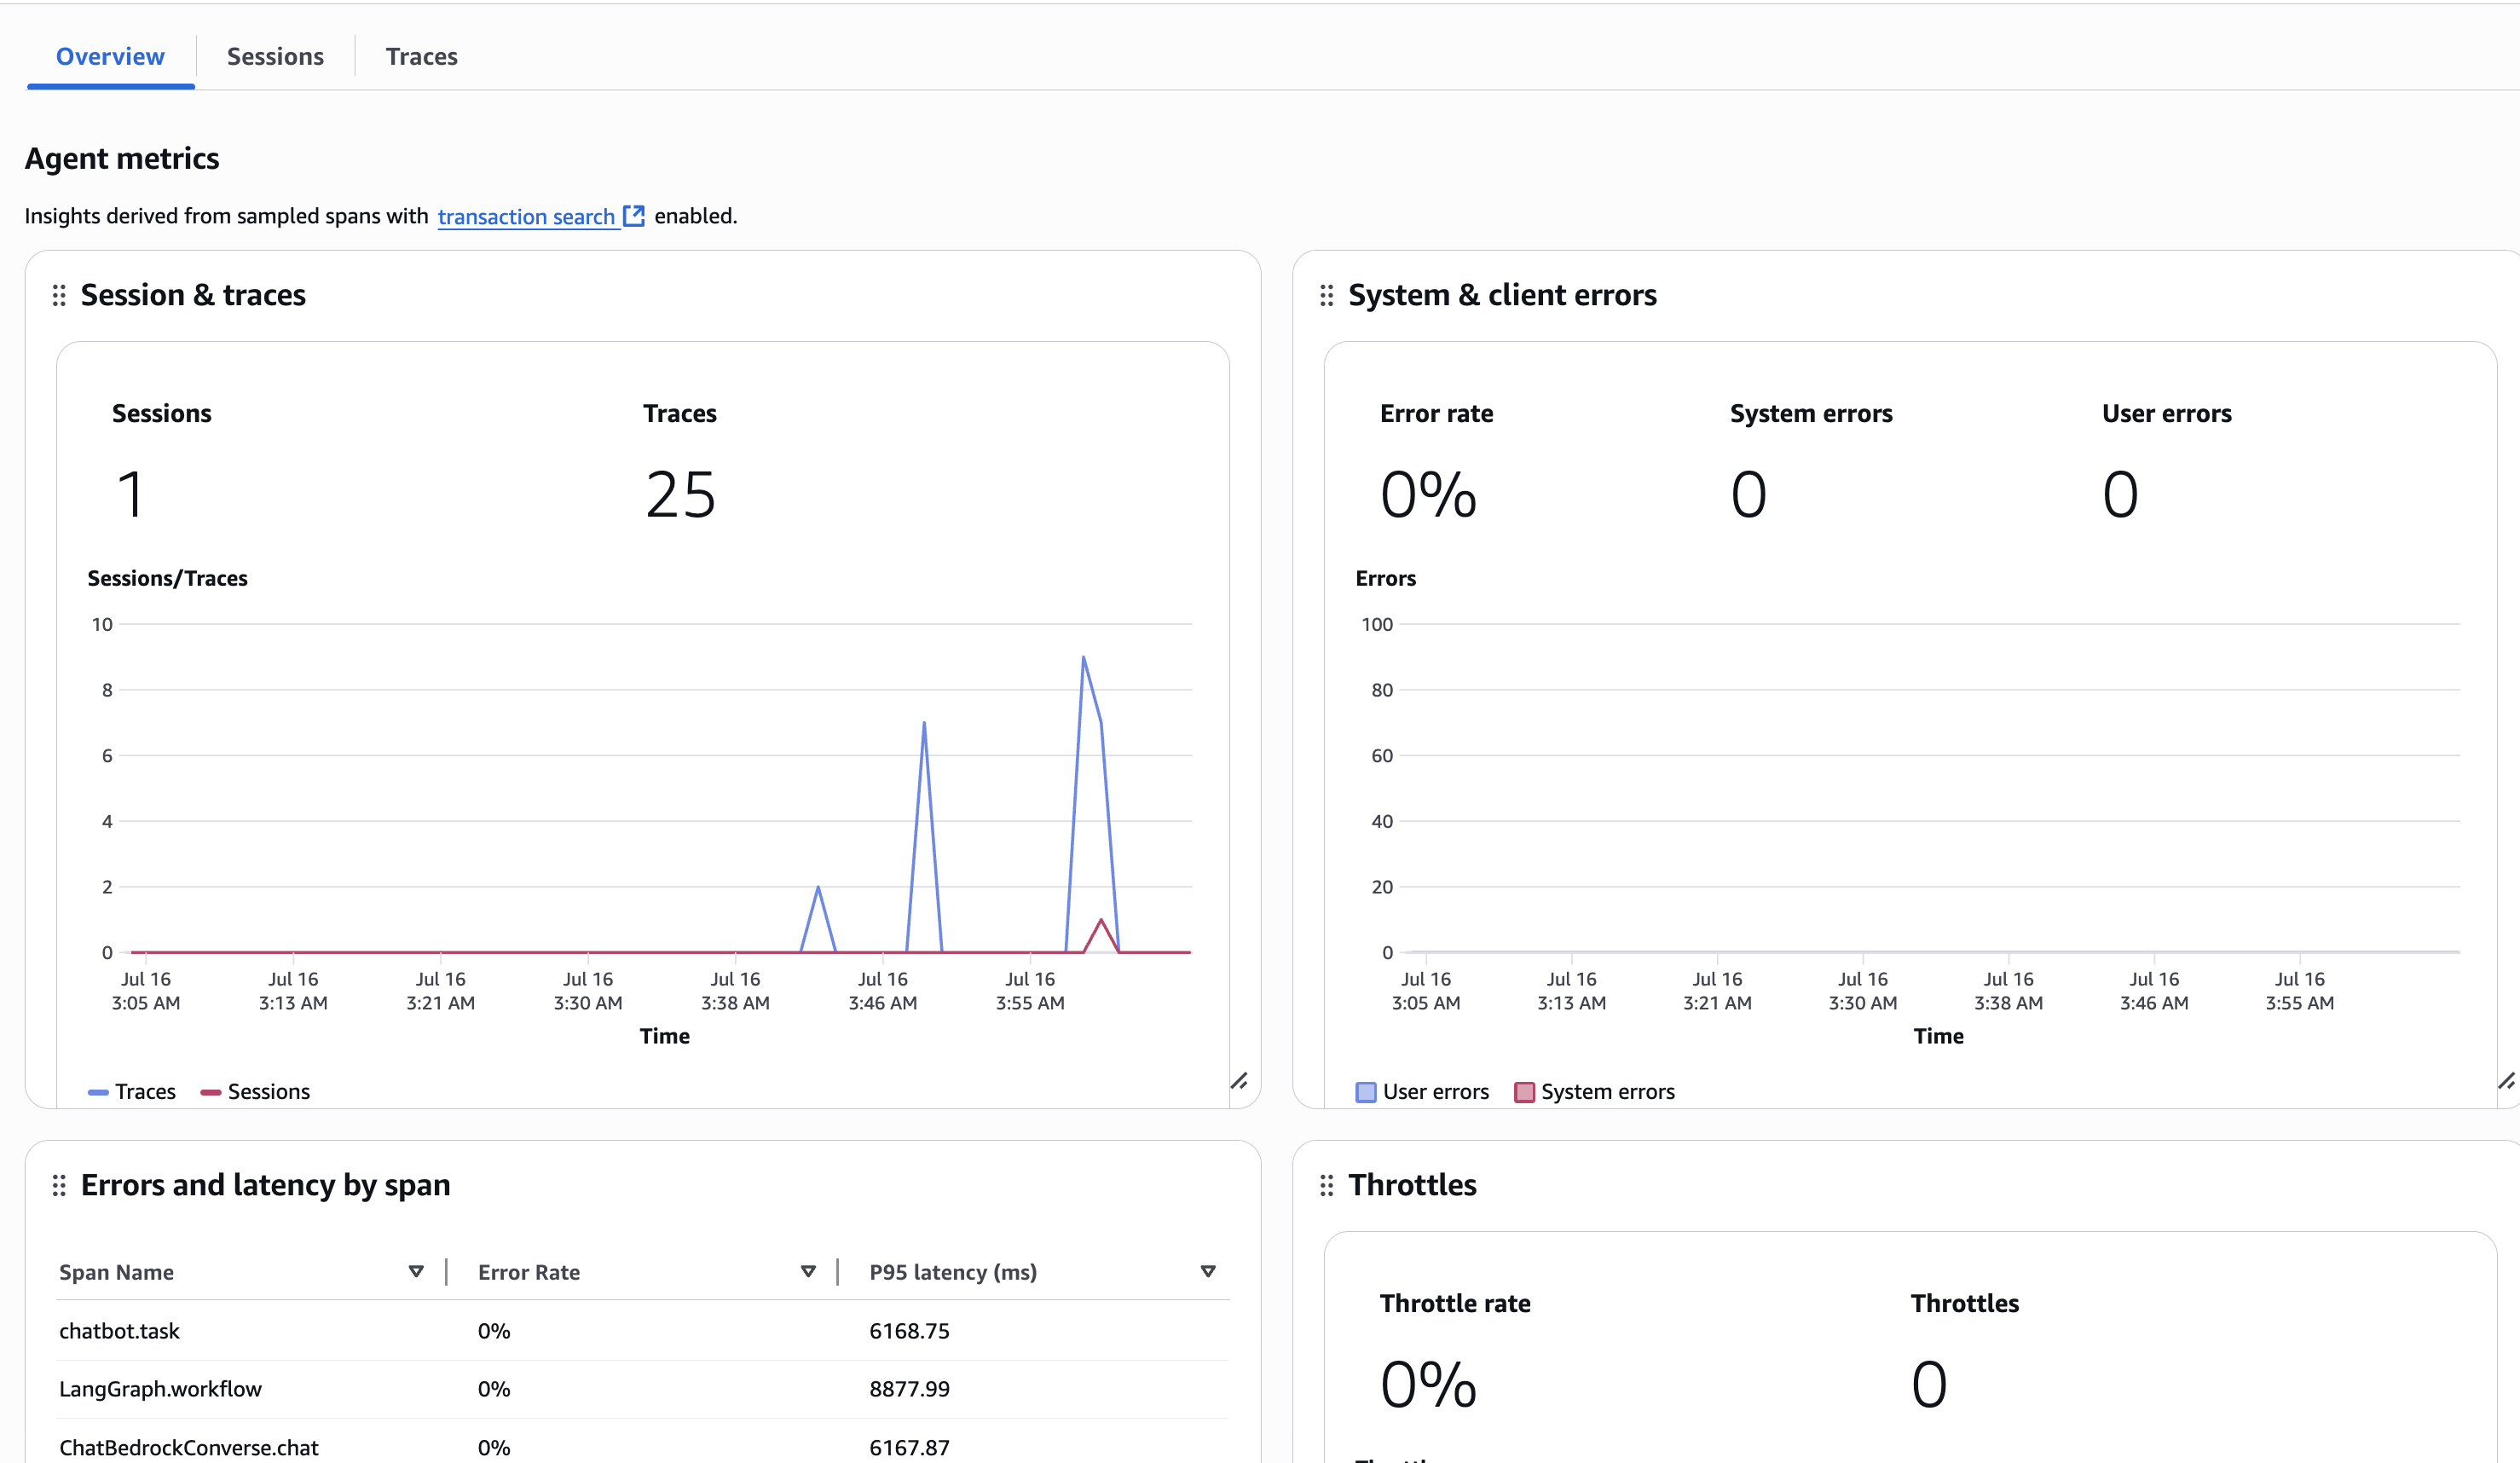

#### Trace View Page:
Trace View:
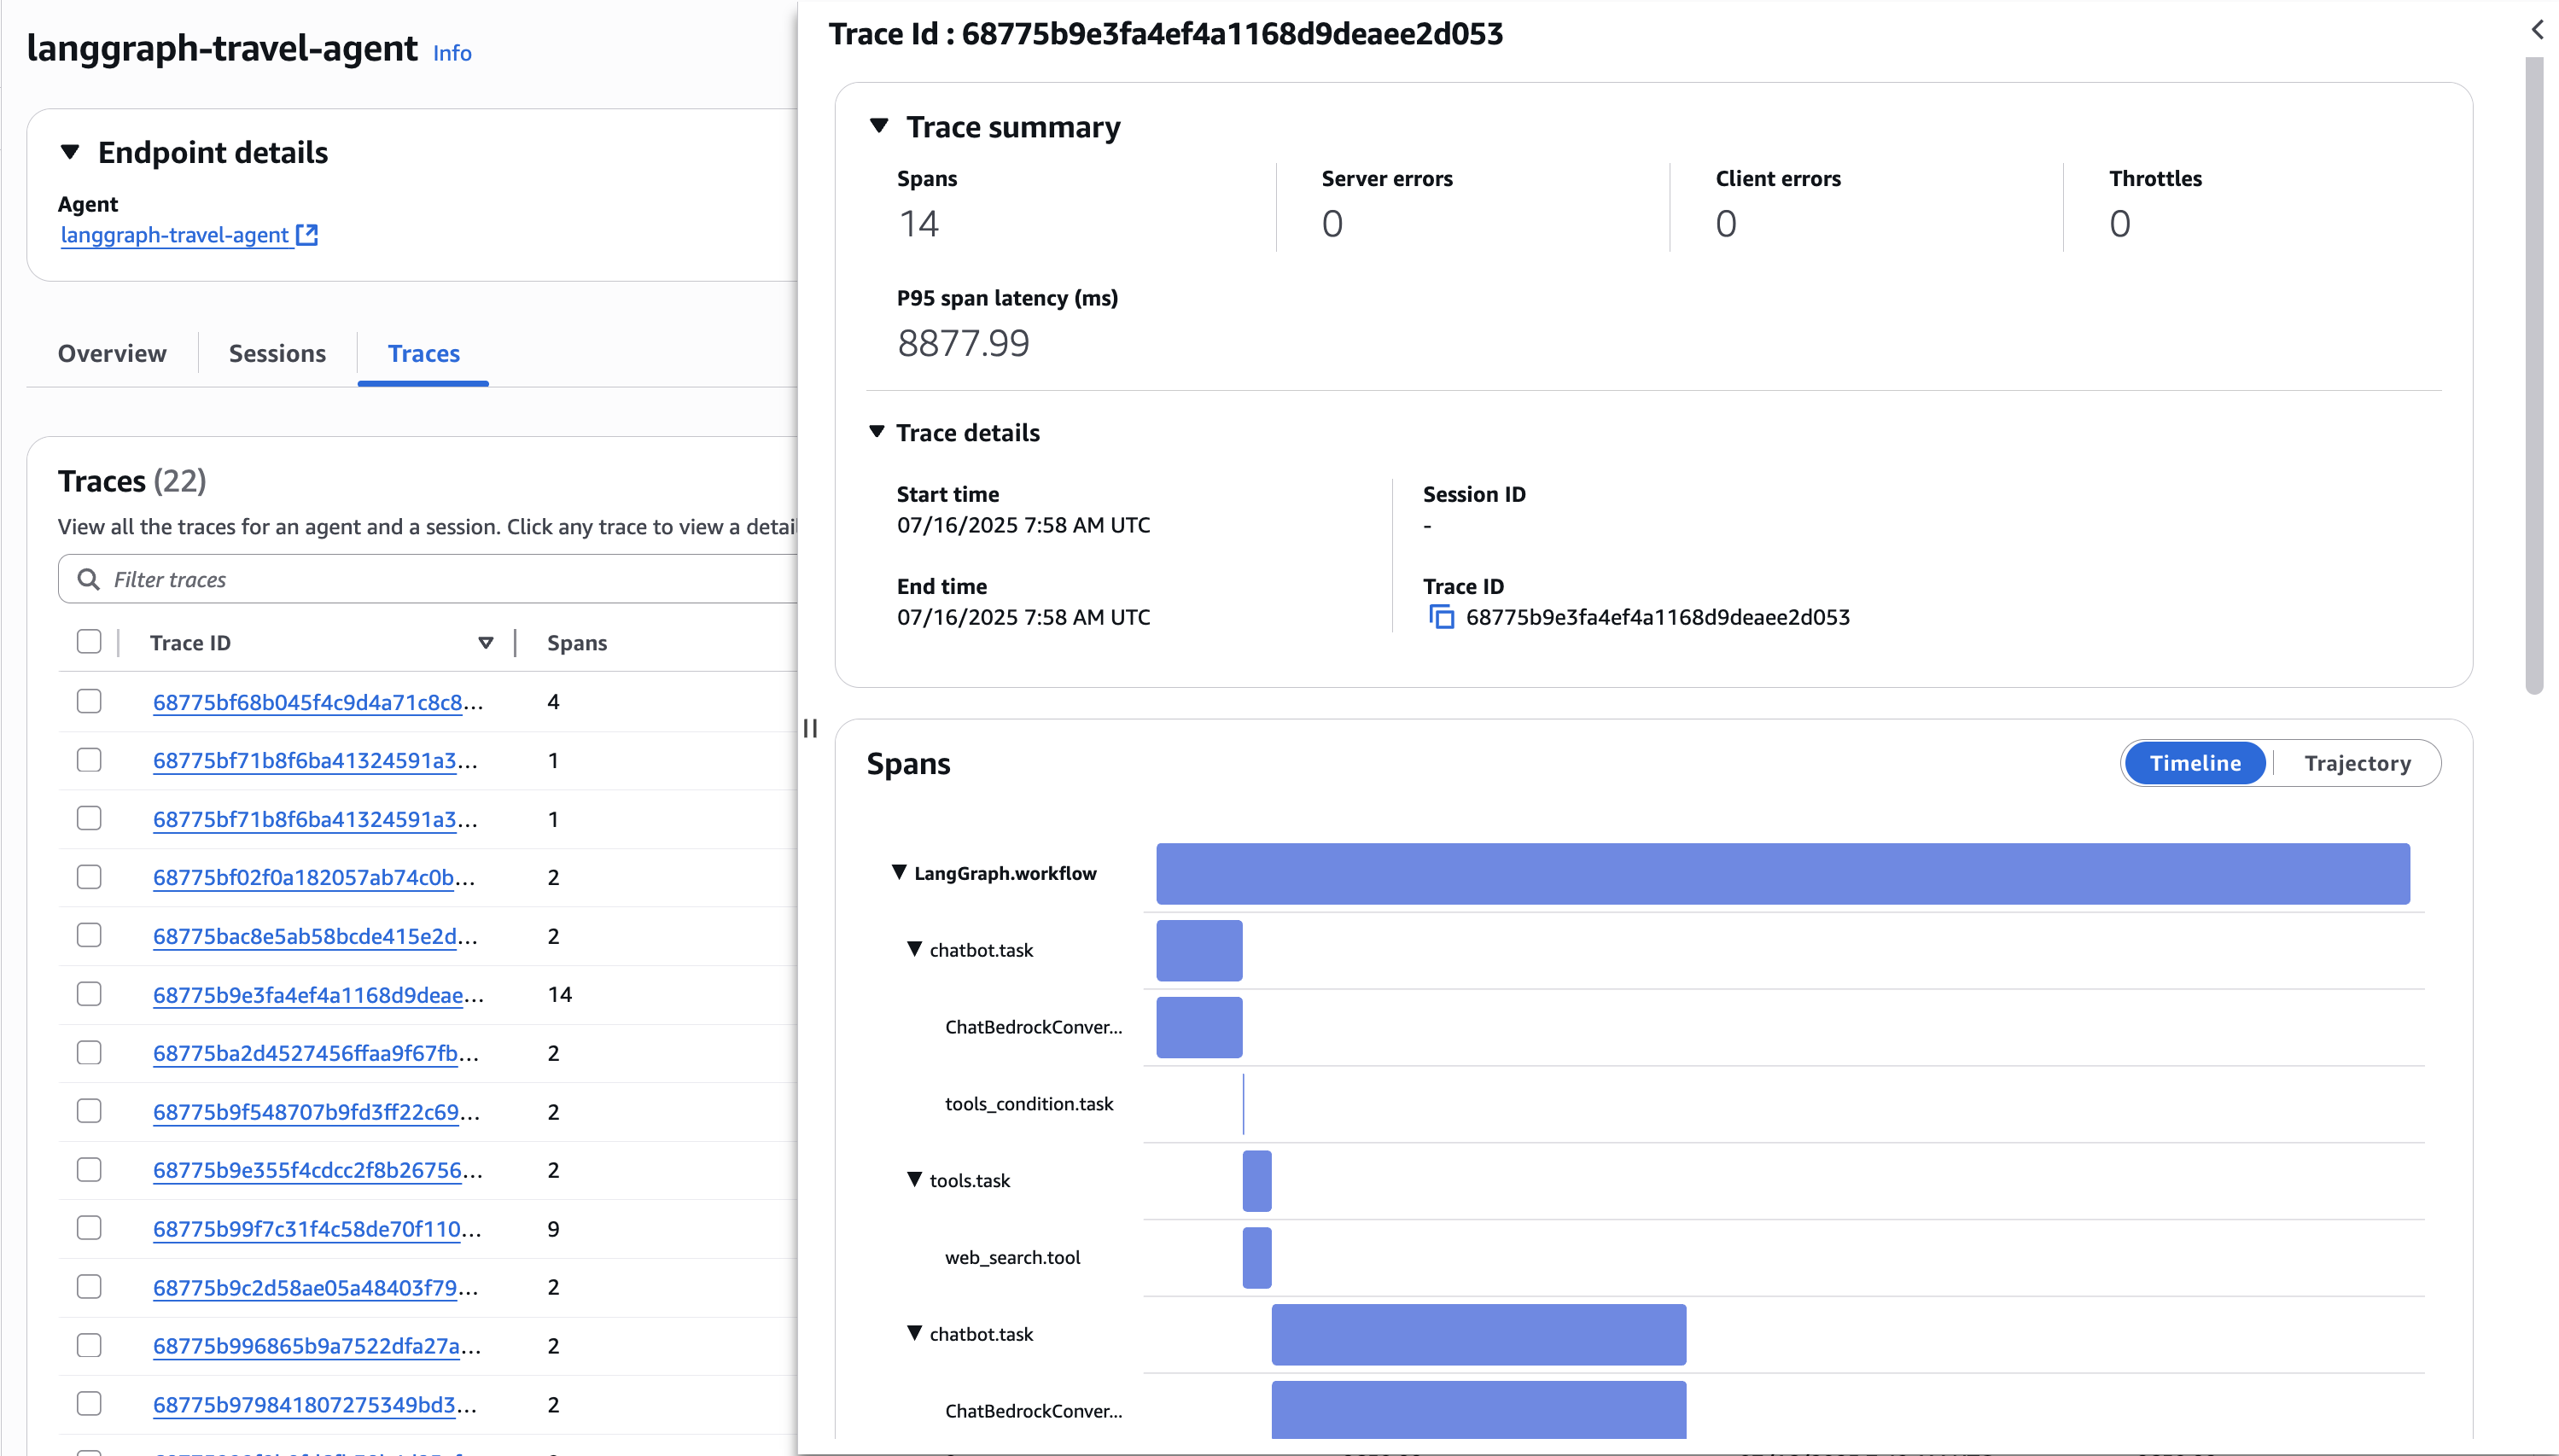

Trace details:
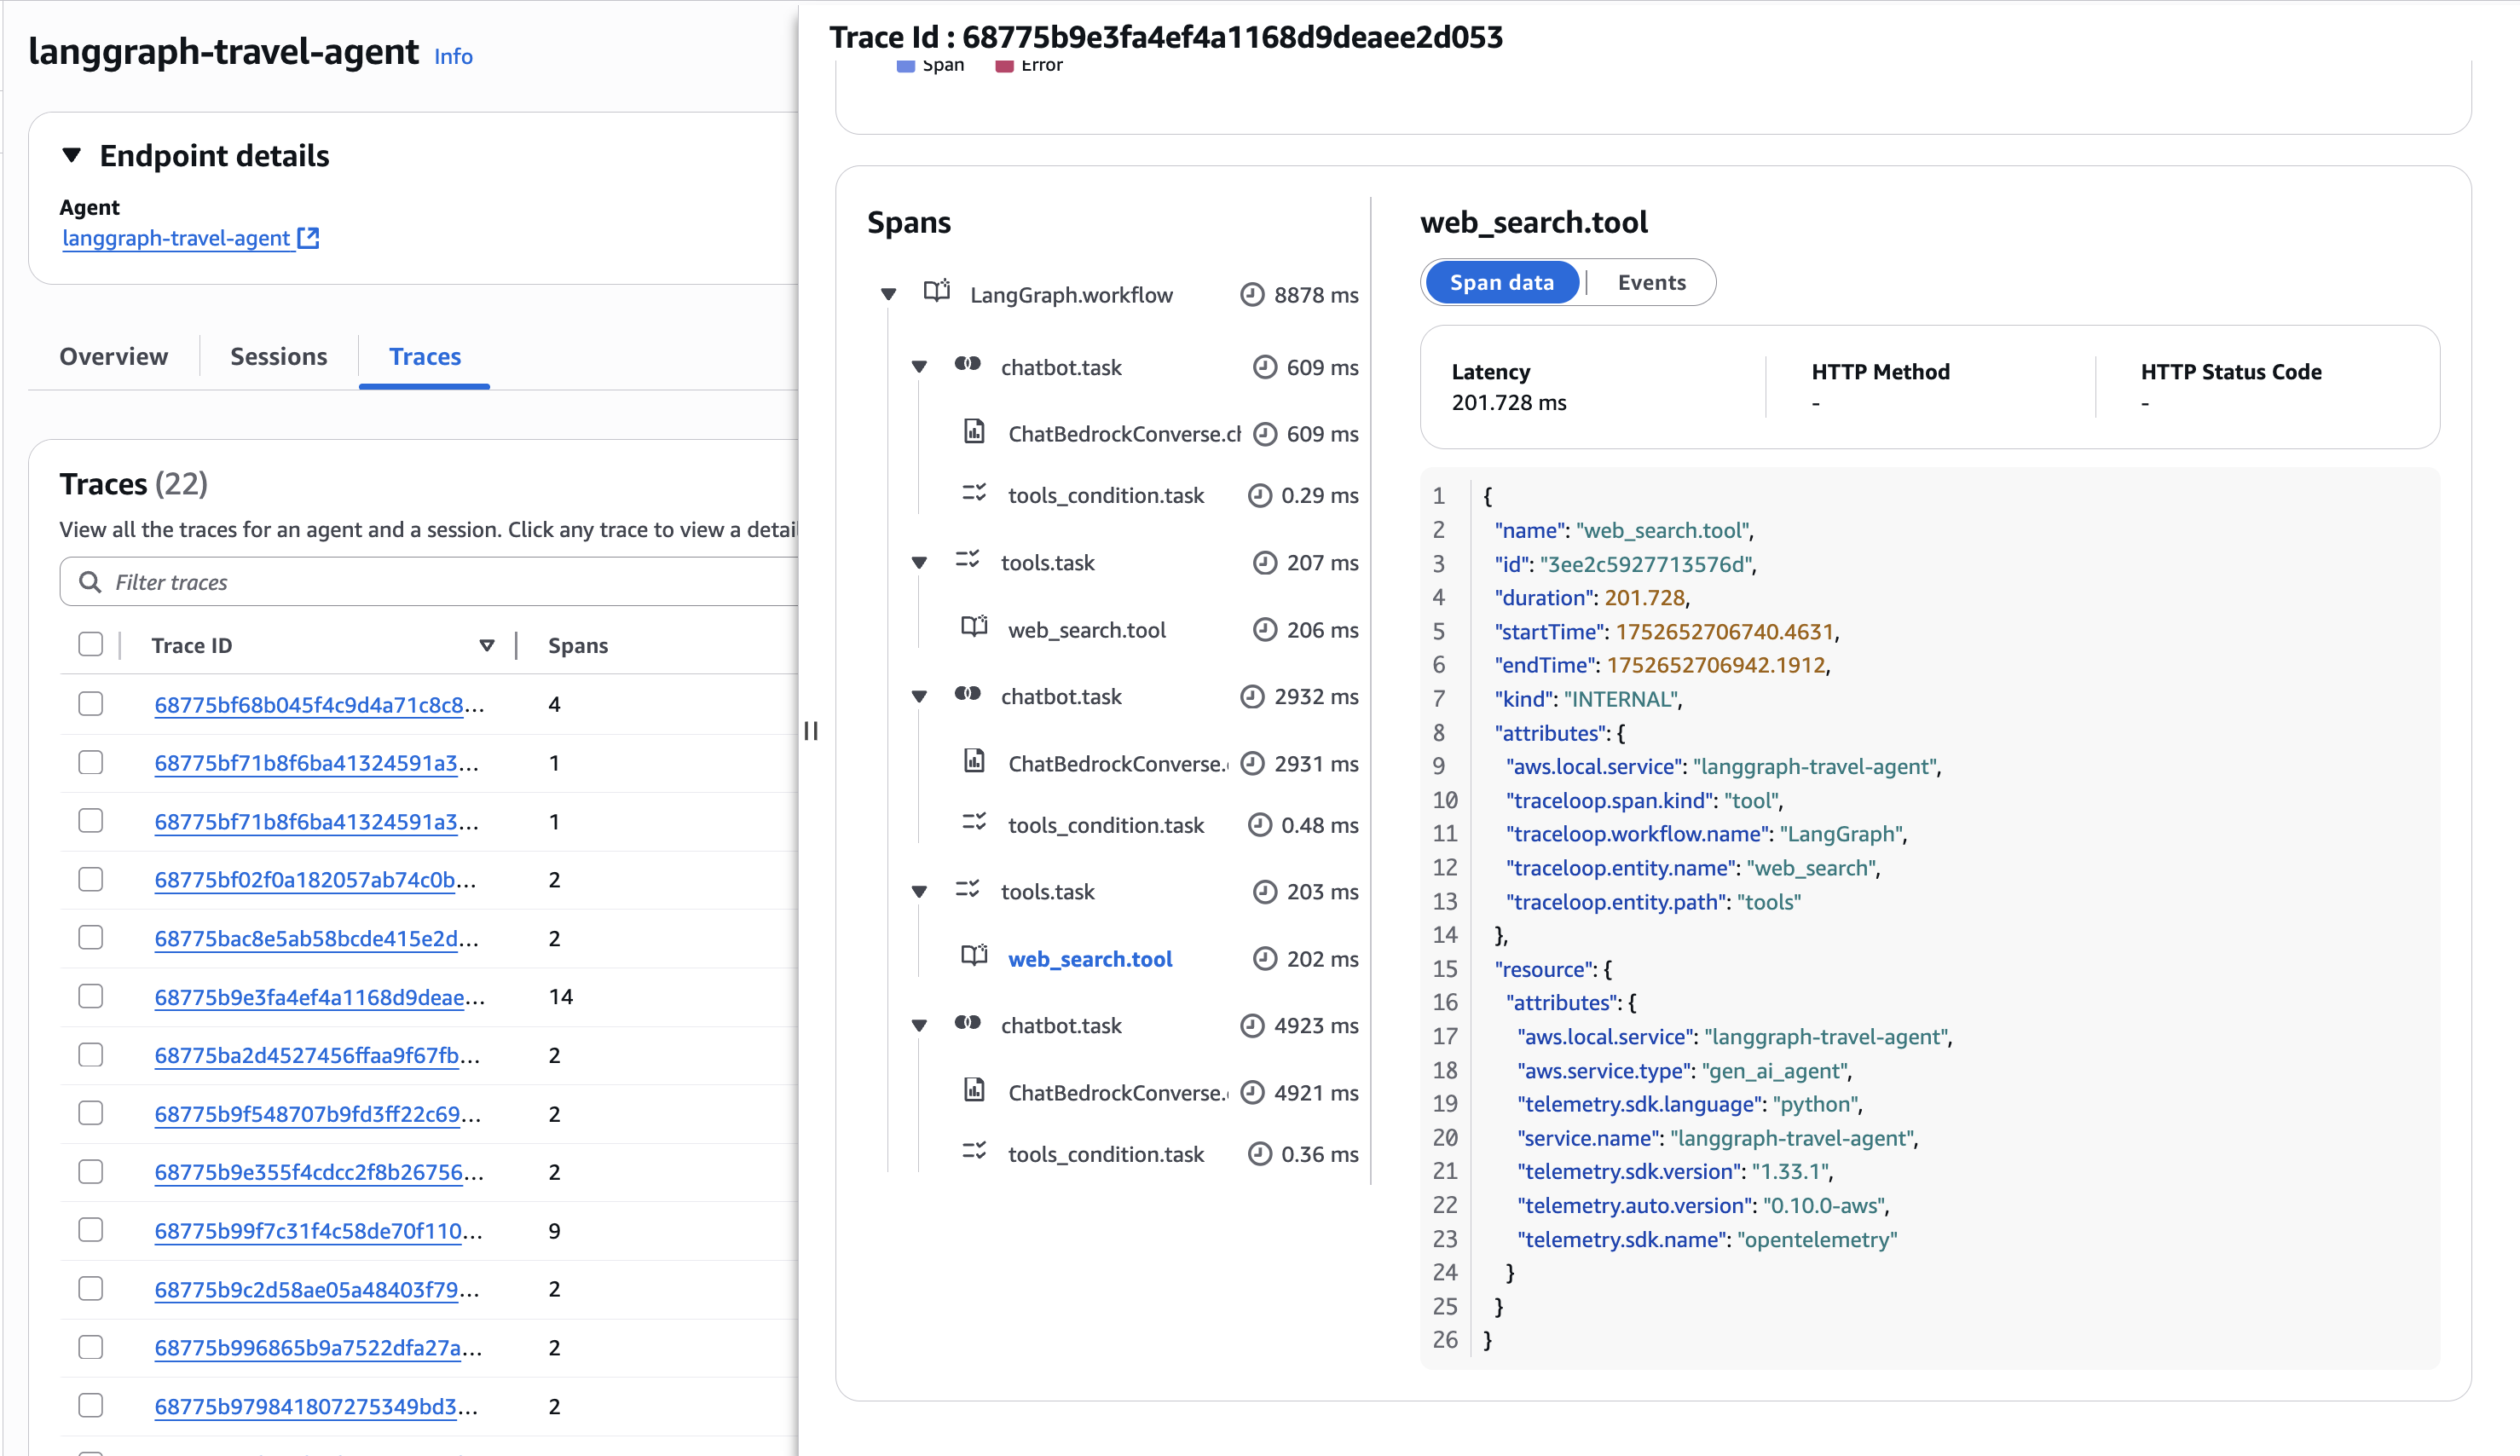


## 9. Troubleshooting

If you're not seeing traces in Amazon CloudWatch check the following:

1. **AWS Credentials**: Ensure your AWS credentials are properly configured
2. **IAM Permissions**: Make sure your IAM user/role has permissions for CloudWatch
3. **Region and Log group**: Confirm you're looking in the correct AWS region and Log groups
4. **Environment Variables**: Verify all OTEL_* environment variables are set correctly



## 10. Conclusion 

Congratulations! You have implemented and instrumented a LangGraph agent with Amazon Bedrock Model which has observability through Amazon CloudWatch. 

- Langgraph travel agent.
- Full OpenTelemetry tracing to AWS CloudWatch
- Traces for Amazon Bedrock calls, Langgraph operations, etc.
 

## 11. Next Steps

Now that you have LangGraph Agent with OpenTelemetry set up, you can:

1. **Add More Agents**: Create a multi-agent Langgraph
2. **Add Tools to your agent**: Integrate various API tools, or custom tools
3. **[Set Up Alarms](https://docs.aws.amazon.com/AmazonCloudWatch/latest/monitoring/AlarmThatSendsEmail.html)**: Create alarms on the metrics that are important to your business like `latency`, `token input`, and `token output` etc..
